# Road Infrastructure Climate Risk Assessment Framework
## RICRAF Road and Climate Data Fusion
---

## Overview

This notebook processes raw open-source raw road and climate datasets for the **Road Infrastructure Climate Risk Assessment Framework (RICRAF)**. It fuses multiple road datasets (traffic volume, road width, and pavement condition) and integrates them with climate hazard data (e.g. extreme rainfall, temperature, drought). The output is a unified GeoJSON dataset adhering to FAIR (Findable, Accessible, Interoperable, Reusable) principles for reproducibility in academic and applied settings.

The workflow is divided into stages:
1. **Fuse Road Datasets**: Merge traffic volume, road width, and pavement condition data.
2. **Fuse Road and Climate Datasets**: Spatially join the fused road data with climate variables.
3. **Final Data Cleaning**: Handle missing values, compute derived features, and ensure data quality.

### Key Features

- **Input Data Sources**:
  - Road data: DataVic (traffic volume, pavement condition, road width).
  - Climate data: Australian Climate Service (heatwaves, rainfall, etc.), for various Global Warming Levels (GWL: current 1.2°C, 1.5°C, 2.0°C, 3.0°C).

- **Output**:
  - Fused GeoJSON dataset (`gdf_road_clim_cln.geojson`).
  - Interim files in `../data/interim/` for debugging and reproducibility.

- **Reproducibility**: All steps are scripted with modular functions from `src/`.

- **Dependencies**: Listed in `requirements.txt` (e.g. geopandas==0.14.4).


### Usage Instructions
1. Install dependencies: `pip install -r requirements.txt`.
2. Run cells sequentially.
3. Outputs are saved to `data/interim/` and `data/processed/`.

For full documentation, see the [RICRAF Data Paper](link-to-paper) (submitted to *TO BE DETERMINED*).


**Notes:**
- All spatial operations use EPSG:3111 (GDA94 / Vicgrid) for Victoria, Australia. Adapt CRS for other regions.
- This notebook emphasises reproducibility: Use virtual environments and document all steps.
- For large datasets, ensure sufficient memory (e.g. 16GB+ RAM).
- Large files are linked via DOI; raw data is not stored in the repository.
- Citation: If using this code or data, cite the associated papers and this repository (DOI via Zenodo).


**Dependencies:**
- Python 3.12+
- geopandas==1.0.1
- pandas==2.2.3
- numpy==2.1.3
- shapely==2.0.6
- pip contextily == 1.6.2
- loguru==0.7.3

Install via `requirements.txt` or uncomment the installation cells below.


In [1]:
# Uncomment to install dependencies if needed
# %conda install geopandas==1.0.1
# %pip install pandas==2.2.3
# %pip install -U numpy==2.1.3
# %pip install shapely==2.0.
# %pip contextily == 1.6.2
# %pip install loguru == 0.7.3

## Stage 1: Fuse Road Datasets

This stage loads the following three raw road datasets, cleans them (removing duplicates and invalid geometries), and fuses them using spatial and attribute matching:
- Traffic Volume (from DataVic).
- Road Width and Number of Lanes (from DataVic).
- Pavement Condition (from DataVic).
The fused road dataset serves as the base for climate integration.

**Key Steps:**
- Load and reproject datasets to Vicgrid (EPSG:3111).
- Clean duplicates and null geometries.
- Fuse traffic volume with road width/lanes and pavement condition.
- Output interim fused datasets for verification.

Data is cleaned (duplicates removed, NoneType geometries handled), and fused using spatial and attribute matching. Outputs are saved in `../data/interim/` for traceability.



In [2]:
import os
import sys
from datetime import datetime
import geopandas as gpd

# Add project root to path for custom module imports
sys.path.append('..')
from src.ricraf_data_fusion import fuse_road_data  # Custom fusion function

# Define parameters
now = datetime.now()
data_dir = "../data/interim"
output_dir1 = os.path.join(data_dir, f"ricraf_fuse_data_s1p1")
os.makedirs(output_dir1, exist_ok=True)
output_dir2 = os.path.join(data_dir, f"ricraf_fuse_data_s1p2")
os.makedirs(output_dir2, exist_ok=True)
gda94_vg = 3111  # EPSG code for GDA94 / Vicgrid

# Columns to retain
cols_vol = [
    'OBJECTID_1', 'HMGNS_LN_1', 'LGA_SHORT_', 'RGN_LONG_N', 'ROAD_NBR', 'DECLARED_R', 'LOCAL_ROAD',
    'RMA_CLSFCN', 'SRNS_CD', 'FLOW', 'ALLVEHS_AA', 'TRUCKS_AAD', 'LABEL', 'geometry',
]
cols_lwd = [
    'OBJECTID', 'ROAD_NUMBE', 'ROAD_NAME', 'DIRECTION', 'SURFACE_TY', 'ELEMENTS',
    'SEAL_WIDTH', 'geometry',
]
cols_pav = [
    'OBJECTID', 'Classified', 'Name_Part', 'Road_Type_', 'Direction', 'Region', 'RMA_Class',
    'Federal_Ro', 'Surface_Ty', 'Roughness_', 'HATI_Categ', 'Texture__L', 'Texture__B',
    'Rutting_Ca', 'Cracking_C', 'geometry',
]

# Load and reproject datasets with error handling
try:
    gdf_vol = gpd.read_file("../data/raw/road_data/Traffic_Volume.shp").to_crs(epsg=gda94_vg)[cols_vol]
    gdf_lwd = gpd.read_file("../data/raw/road_data/Road_Width_and_Number_of_Lanes.shp").to_crs(epsg=gda94_vg)[cols_lwd]
    gdf_pav = gpd.read_file("../data/raw/road_data/Pavement_Condition_Data.shp").to_crs(epsg=gda94_vg)[cols_pav]
    print(f"Raw gdf_vol records: {len(gdf_vol)}")
    print(f"Raw gdf_lwd records: {len(gdf_lwd)}")
    print(f"Raw gdf_pav records: {len(gdf_pav)}")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Raw data file not found: {e}")

# Clean datasets: Remove duplicates
gdf_vol_cln = gdf_vol.drop_duplicates(subset=["HMGNS_LN_1", "FLOW", "LABEL", "geometry"], keep='first')
gdf_lwd_cln = gdf_lwd.drop_duplicates(subset=["ROAD_NAME", "DIRECTION", "ELEMENTS", "SURFACE_TY", "geometry"], keep='first')
gdf_pav_cln = gdf_pav.drop_duplicates(subset=["Name_Part", "Road_Type_", "Direction", "Surface_Ty",  "geometry"], keep='first')
print(f"Removed duplicates - gdf_vol records: {len(gdf_vol_cln)}")
print(f"Removed duplicates - gdf_lwd records: {len(gdf_lwd_cln)}")
print(f"Removed duplicates - gdf_pav records: {len(gdf_pav_cln)}")

# Remove invalid (NoneType) geometries
gdf_vol_cln = gdf_vol_cln[gdf_vol_cln['geometry'].notna()]
gdf_lwd_cln = gdf_lwd_cln[gdf_lwd_cln['geometry'].notna()]
gdf_pav_cln = gdf_pav_cln[gdf_pav_cln['geometry'].notna()]
print(f"Cleaned gdf_vol records (removed NoneType geometries): {len(gdf_vol_cln)}")
print(f"Cleaned gdf_lwd records (removed NoneType geometries): {len(gdf_lwd_cln)}")
print(f"Cleaned gdf_pav records (removed NoneType geometries): {len(gdf_pav_cln)}")

# Rename OBJECTID columns to avoid conflicts
gdf_lwd_cln = gdf_lwd_cln.rename(columns={"OBJECTID": "OBJECTID_LWD"})
gdf_pav_cln = gdf_pav_cln.rename(columns={"OBJECTID": "OBJECTID_PAV"})

# Create ROAD_NAME in pavement data for matching
gdf_pav_cln["ROAD_NAME"] = gdf_pav_cln["Name_Part"] + " " + gdf_pav_cln["Road_Type_"]

# Verify and clean key columns (drop rows with nulls in matching columns)
main_cols = ["ROAD_NBR", "HMGNS_LN_1", "DECLARED_R"]
supp_cols1 = ["ROAD_NUMBE", "ROAD_NAME"]
supp_cols2 = ["Classified", "ROAD_NAME"]
gdf_vol_cln = gdf_vol_cln.dropna(subset=main_cols)
gdf_lwd_cln = gdf_lwd_cln.dropna(subset=supp_cols1)
gdf_pav_cln = gdf_pav_cln.dropna(subset=supp_cols2)
print(f"Cleaned gdf_vol records (removed nulls in key columns): {len(gdf_vol_cln)}")
print(f"Cleaned gdf_lwd records (removed nulls in key columns): {len(gdf_lwd_cln)}")
print(f"Cleaned gdf_pav records (removed nulls in key columns): {len(gdf_pav_cln)}")

# Validate column presence and null counts
for col in main_cols:
    if col not in gdf_vol_cln.columns:
        raise ValueError(f"Column '{col}' not found in gdf_vol")
    print(f"gdf_vol['{col}'] null count: {gdf_vol_cln[col].isna().sum()}")
for col in supp_cols1:
    if col not in gdf_lwd_cln.columns:
        raise ValueError(f"Column '{col}' not found in gdf_lwd")
    print(f"gdf_lwd['{col}'] null count: {gdf_lwd_cln[col].isna().sum()}")
for col in supp_cols2:
    if col not in gdf_pav_cln.columns:
        raise ValueError(f"Column '{col}' not found in gdf_pav")
    print(f"gdf_pav['{col}'] null count: {gdf_pav_cln[col].isna().sum()}")

# Step 1: Fuse Traffic Volume and Road Width/Lanes
gdf_vol_rd_cfg, gdf_supp_matched, gdf_supp_unmatched, gdf_issues, gdf_main_split_rows, gdf_supp_split_rows = fuse_road_data(
    gdf_main=gdf_vol_cln,
    gdf_supp=gdf_lwd_cln,
    output_dir=output_dir1,
    main_road_num_col="ROAD_NBR",
    supp_road_num_col="ROAD_NUMBE",
    main_road_name_cols=["HMGNS_LN_1", "DECLARED_R"],
    supp_road_name_col="ROAD_NAME",
    verification_id_col="OBJECTID_LWD",
    log_level_console="WARNING",
    log_level_file="DEBUG",
    output_format="GeoJSON",
    output_name="gdf_vol_rd_cfg"
)

# Validate Step 1 Outputs
print(f"Total gdf_vol_cln rows: {len(gdf_vol_cln)}")
print(f"Matched records: {len(gdf_vol_rd_cfg)}")
print(f"Supplementary matched: {len(gdf_supp_matched)}")
print(f"Supplementary unmatched: {len(gdf_supp_unmatched)}")
print(f"Issues found: {len(gdf_issues)}")

# Step 2: Fuse with Pavement Condition
gdf_vol_rd_pav, gdf_supp_matched2, gdf_supp_unmatched2, gdf_issues2, gdf_main_split_rows2, gdf_supp_split_rows2 = fuse_road_data(
    gdf_main=gdf_vol_rd_cfg,
    gdf_supp=gdf_pav_cln,
    output_dir=output_dir2,
    main_road_num_col="ROAD_NBR",
    supp_road_num_col="Classified",
    main_road_name_cols=["HMGNS_LN_1", "DECLARED_R"],
    supp_road_name_col="ROAD_NAME",
    verification_id_col="OBJECTID_PAV",
    log_level_console="WARNING",
    log_level_file="DEBUG",
    output_format="GeoJSON",
    output_name="gdf_vol_rd_pav"
)

# Validate Step 2 Outputs
print(f"Total gdf_vol_rd_cfg rows: {len(gdf_vol_rd_cfg)}")
print(f"Matched records: {len(gdf_vol_rd_pav)}")
print(f"Supplementary matched: {len(gdf_supp_matched2)}")
print(f"Supplementary unmatched: {len(gdf_supp_unmatched2)}")
print(f"Issues found: {len(gdf_issues2)}")

Raw gdf_vol records: 14674
Raw gdf_lwd records: 74711
Raw gdf_pav records: 238837
Removed duplicates - gdf_vol records: 14647
Removed duplicates - gdf_lwd records: 74710
Removed duplicates - gdf_pav records: 238722
Cleaned gdf_vol records (removed NoneType geometries): 14647
Cleaned gdf_lwd records (removed NoneType geometries): 74691
Cleaned gdf_pav records (removed NoneType geometries): 238721
Cleaned gdf_vol records (removed nulls in key columns): 14639
Cleaned gdf_lwd records (removed nulls in key columns): 74691
Cleaned gdf_pav records (removed nulls in key columns): 238668
gdf_vol['ROAD_NBR'] null count: 0
gdf_vol['HMGNS_LN_1'] null count: 0
gdf_vol['DECLARED_R'] null count: 0
gdf_lwd['ROAD_NUMBE'] null count: 0
gdf_lwd['ROAD_NAME'] null count: 0
gdf_pav['Classified'] null count: 0
gdf_pav['ROAD_NAME'] null count: 0


2025-10-20 00:37:49.649 | WARNING  | src.ricraf_data_fusion:fuse_road_data:440 - Found 1458 records with mismatched Travel_Dir or Part_Rd_Name/Part_DRd_Name


Total gdf_vol_cln rows: 14639
Matched records: 14647
Supplementary matched: 70202
Supplementary unmatched: 4490
Issues found: 1458


2025-10-20 00:47:40.135 | WARNING  | src.ricraf_data_fusion:fuse_road_data:440 - Found 2171 records with mismatched Travel_Dir or Part_Rd_Name/Part_DRd_Name


Total gdf_vol_rd_cfg rows: 14647
Matched records: 14647
Supplementary matched: 428660
Supplementary unmatched: 46182
Issues found: 2171


## Stage 2: Fuse Road and Climate Datasets

This stage spatially joins the fused road data with climate datasets (e.g. rainfall, temperature) from the Australian Climate Service. Climate values are aggregated (mean) over intersecting road segments. Missing values are handled via nearest-neighbor interpolation.

The result is a comprehensive geospatial dataset ready for climate risk model development and assessment.


**Key Steps:**
- Define climate variables and target columns.
- Perform spatial joins and handle nulls.
- Output the road-climate fused dataset and save in `../data/interim/` for traceability.


In [3]:
import os
import sys
import pandas as pd
import geopandas as gpd
from datetime import datetime

# Add project root to path for custom module imports
sys.path.append('..')
from src.ricraf_data_fusion import merge_road_climate  # Custom merge function

# CRS definitions
crs_wgs84 = 4326
crs_vic = 3111

# User-configurable settings
now = datetime.now()
data_dir = "../data/interim"
state_crs = crs_vic
input_dir = "../data/raw/climate_data"
output_dir = os.path.join(data_dir, f"ricraf_fuse_data_s2")
os.makedirs(output_dir, exist_ok=True)
road_file = f"{data_dir}/ricraf_fuse_data_s1p2/gdf_vol_rd_pav.geojson"

# Define road columns to keep
cols_road = [
    'OBJECTID_1', 'HMGNS_LN_1', 'LGA_SHORT_', 'RGN_LONG_N', 'ROAD_NBR',
    'DECLARED_R', 'LOCAL_ROAD', 'RMA_CLSFCN', 'SRNS_CD', 'ALLVEHS_AA', 'TRUCKS_AAD',
    'SEAL_WIDTH', 'Surface_Ty', 'HATI_Categ', 'Texture__L', 'Texture__B',
    'FLOW', 'Roughness_', 'Rutting_Ca', 'Cracking_C', 'geometry'
]

# Load road dataset
gdf_road = gpd.read_file(road_file)[cols_road].to_crs(epsg=state_crs)
print(f"Number of records in road dataset: {len(gdf_road)}")

# Define climate datasets and target columns
climate_variables = {
    f"{input_dir}/extreme_rainfall_aus_rx5d_gwl-current_250316_vic.json": 'rx5d_gwl-current',
    f"{input_dir}/extreme_temperature_aus_tn02_gwl-current_250316_vic.json": "tn02_gwl-current",
    f"{input_dir}/extreme_temperature_aus_tx40_gwl-current_250316_vic.json":"tx40_gwl-current",
    f"{input_dir}/temperature_aus_tgm_max_gwl-current_250317_vic.json": "tgm_max_gwl-current",
    f"{input_dir}/temperature_aus_tgm_min_gwl-current_250317_vic.json": "tgm_min_gwl-current",
    f"{input_dir}/drought_aridity_aus_spi3_gwl-current_250316_vic.json": "spi3_gwl-current",
    f"{input_dir}/extreme_rainfall_aus_rx5d_gwl-1.5_250316_vic.json": 'rx5d_gwl-1.5',
    f"{input_dir}/extreme_temperature_aus_tn02_gwl-1.5_250316_vic.json": "tn02_gwl-1.5",
    f"{input_dir}/extreme_temperature_aus_tx40_gwl-1.5_250316_vic.json":"tx40_gwl-1.5",
    f"{input_dir}/temperature_aus_tgm_max_gwl-1.5_250317_vic.json": "tgm_max_gwl-1.5",
    f"{input_dir}/temperature_aus_tgm_min_gwl-1.5_250317_vic.json": "tgm_min_gwl-1.5",
    f"{input_dir}/drought_aridity_aus_spi3_gwl-1.5_250316_vic.json": "spi3_gwl-1.5",
    f"{input_dir}/extreme_rainfall_aus_rx5d_gwl-2_250316_vic.json": 'rx5d_gwl-2.0',
    f"{input_dir}/extreme_temperature_aus_tn02_gwl-2_250316_vic.json": "tn02_gwl-2.0",
    f"{input_dir}/extreme_temperature_aus_tx40_gwl-2_250316_vic.json":"tx40_gwl-2.0",
    f"{input_dir}/temperature_aus_tgm_max_gwl-2_250317_vic.json": "tgm_max_gwl-2.0",
    f"{input_dir}/temperature_aus_tgm_min_gwl-2_250317_vic.json": "tgm_min_gwl-2.0",
    f"{input_dir}/drought_aridity_aus_spi3_gwl-2_250316_vic.json": "spi3_gwl-2.0",
    f"{input_dir}/extreme_rainfall_aus_rx5d_gwl-3_250316_vic.json": 'rx5d_gwl-3.0',
    f"{input_dir}/extreme_temperature_aus_tn02_gwl-3_250316_vic.json": "tn02_gwl-3.0",
    f"{input_dir}/extreme_temperature_aus_tx40_gwl-3_250316_vic.json":"tx40_gwl-3.0",
    f"{input_dir}/temperature_aus_tgm_max_gwl-3_250317_vic.json": "tgm_max_gwl-3.0",
    f"{input_dir}/temperature_aus_tgm_min_gwl-3_250317_vic.json": "tgm_min_gwl-3.0",
    f"{input_dir}/drought_aridity_aus_spi3_gwl-3_250316_vic.json": "spi3_gwl-3.0",
}

# Process and merge
try:
    climate_columns_added = 0
    for climate_file, target_col in climate_variables.items():
        print(f"\nProcessing {climate_file}")
        gdf_clim = gpd.read_file(climate_file).to_crs(epsg=state_crs)
        gdf_road = merge_road_climate(gdf_road, gdf_clim, target_col)
        climate_columns_added += 1

    gdf_road_clim = gpd.GeoDataFrame(gdf_road, geometry=gdf_road.geometry, crs=state_crs)
    print(f"\nNumber of records after all merges: {len(gdf_road_clim)}")
    print(f"Total climate columns added: {climate_columns_added}")

    climate_cols = list(climate_variables.values())
    null_counts = gdf_road_clim[climate_cols].isna().sum()
    print("\nNull counts in climate columns:")
    print(null_counts)
    if null_counts.sum() > 0:
        print("Warning: Some climate columns contain null values.")
    else:
        print("All climate columns are fully populated.")

except Exception as e:
    print(f"Error during merge: {str(e)}")

# Save results
if 'gdf_road_clim' in locals():
    output_file = os.path.join(output_dir, "gdf_road_clim.geojson")
    gdf_road_clim.to_file(output_file, driver='GeoJSON')
    print(f"\nFused dataset saved to {output_file}")
    gdf_road_clim_cln = gdf_road_clim.dropna(how="any")
    output_file_cln = os.path.join(output_dir, "gdf_road_clim_cln.geojson")
    gdf_road_clim_cln.to_file(output_file_cln, driver='GeoJSON')
    print(f"Cleaned dataset saved to {output_file_cln}")

Number of records in road dataset: 14647

Processing ../data/raw/climate_data/extreme_rainfall_aus_rx5d_gwl-current_250316_vic.json
Mapping 'rx5d_gwl-c' to 'rx5d_gwl-current'
Number of non-null records for 'rx5d_gwl-current': 14647

Processing ../data/raw/climate_data/extreme_temperature_aus_tn02_gwl-current_250316_vic.json
Mapping 'tn02_gwl-c' to 'tn02_gwl-current'
Number of non-null records for 'tn02_gwl-current': 14647

Processing ../data/raw/climate_data/extreme_temperature_aus_tx40_gwl-current_250316_vic.json
Mapping 'tx40_gwl-c' to 'tx40_gwl-current'
Number of non-null records for 'tx40_gwl-current': 14647

Processing ../data/raw/climate_data/temperature_aus_tgm_max_gwl-current_250317_vic.json
Mapping 'tgm_max_gw' to 'tgm_max_gwl-current'
Number of non-null records for 'tgm_max_gwl-current': 14647

Processing ../data/raw/climate_data/temperature_aus_tgm_min_gwl-current_250317_vic.json
Mapping 'tgm_min_gw' to 'tgm_min_gwl-current'
Number of non-null records for 'tgm_min_gwl-curren

## Stage 3: Final Data Cleaning and Preparation

This stage performs final cleaning, imputation, and feature engineering on the fused dataset.

**Key Steps:**
- Map categorical values (e.g. surface types to descriptive labels).
- Impute zero values in temperature columns using nearest neighbors.
- Compute additional features (e.g. link length, non-truck AADT).
- Generate unique road link IDs.
- Drop remaining nulls and save the final dataset.

The final output is `gdf_road_clim_cln.geojson` in `../data/processed/`.


In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load fused road-climate dataset
gdf = gpd.read_file("../data/interim/ricraf_fuse_data_s2/gdf_road_clim_cln.geojson")
print(f"Initial dataset size: {len(gdf)} road links")

# Map surface types
surface_type_mapping = {
    'S': 'Stone Seal', 'A': 'Asphalt', 'U': 'Ultra Thin Asphalt',
    'C': 'Concrete', 'H': 'High Friction Surface Treatment',
    'G': 'Gravel', 'X': 'Other'
}
print("Before mapping:", gdf['Surface_Ty'].unique())
gdf['Surface_Ty'] = gdf['Surface_Ty'].replace(surface_type_mapping)
print("After mapping:", gdf['Surface_Ty'].unique())

# Compute link length
gdf['link_length'] = gdf['geometry'].length

# Impute zero values in GWL temperature columns using nearest neighbor
gwl_columns = [
    'tx40_gwl-current', 'tx40_gwl-1.5', 'tx40_gwl-2.0', 'tx40_gwl-3.0'
]
for col in gwl_columns:
    zero_links = gdf[gdf[col] == 0]
    print(f"Before imputation for {col}=0: {len(zero_links)} road links")
    zero_indices = zero_links.index.tolist()
    for idx in zero_indices:
        current_geom = gdf.loc[idx, 'geometry']
        non_zero_links = gdf[gdf[col] > 0].copy()
        if not non_zero_links.empty:
            non_zero_links['distance'] = non_zero_links['geometry'].apply(lambda x: current_geom.distance(x))
            closest_link = non_zero_links.loc[non_zero_links['distance'].idxmin()]
            gdf.loc[idx, col] = closest_link[col]
    remaining_zero_links = gdf[gdf[col] == 0]
    print(f"After imputation for {col}=0: {len(remaining_zero_links)} road links")

# # Optional EDA: Histogram of imputed temperature values (uncomment to plot)
# import matplotlib.pyplot as plt
# for col in gwl_columns:
#     plt.figure()
#     gdf[col].hist(bins=20)
#     plt.title(f"Distribution of {col}")
#     plt.xlabel(f"{col} - No. of Days")
#     plt.ylabel("Frequency")
#     plt.show()

# Compute non-truck AADT
gdf['NON_TRUCKS_AADT'] = gdf['ALLVEHS_AA'] - gdf['TRUCKS_AAD']

# Generate unique road link IDs
gdf['Segment_Index'] = gdf.groupby('OBJECTID_1').cumcount() + 1
gdf['road_link_id'] = gdf['OBJECTID_1'].astype(str) + '_' + gdf['Segment_Index'].astype(str)
gdf = gdf.drop(columns=['Segment_Index'])
if gdf['road_link_id'].is_unique:
    print("road_link_id is unique.")
else:
    print("Warning: road_link_id is not unique.")

# Final drop of nulls
gdf = gdf.dropna(how='any')
print(f"Final dataset size after dropping nulls: {len(gdf)} road links")

# Save final dataset
fn_gdf_road_clim = "gdf_road_clim_cln_final_withfuture"
gdf.to_file(f"../data/processed/{fn_gdf_road_clim}.geojson", driver='GeoJSON')
print(f"Final dataset saved to '../data/processed/{fn_gdf_road_clim}'.")

# Save to CSV
df = gdf.drop(columns=['geometry'], errors='ignore')
df.to_csv(f"../data/processed/{fn_gdf_road_clim}.csv", index=False)
print(f"Final dataset as CSV to '{csv_output_path}'.")


Initial dataset size: 7579 road links
Before mapping: ['S' 'A' 'C' 'U' 'H' 'G' 'X']
After mapping: ['Stone Seal' 'Asphalt' 'Concrete' 'Ultra Thin Asphalt'
 'High Friction Surface Treatment' 'Gravel' 'Other']
Before imputation for tx40_gwl-current=0: 248 road links
After imputation for tx40_gwl-current=0: 0 road links
Before imputation for tx40_gwl-1.5=0: 239 road links
After imputation for tx40_gwl-1.5=0: 0 road links
Before imputation for tx40_gwl-2.0=0: 238 road links
After imputation for tx40_gwl-2.0=0: 0 road links
Before imputation for tx40_gwl-3.0=0: 232 road links
After imputation for tx40_gwl-3.0=0: 0 road links
road_link_id is unique.
Final dataset size after dropping nulls: 7579 road links
Final dataset saved to '../data/processed/gdf_road_clim_cln_final_withfuture'.
Final dataset as CSV to '../data/processed/gdf_road_clim_cln_final_withfuture.geojson.csv'.


# Data Validation

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.validation import explain_validity

# Load final dataset
gdf = gpd.read_file("../data/processed/gdf_road_clim_cln_final_withfuture.geojson")

# 1. Topology Validation: Check invalid geometries
invalid_geoms = gdf[~gdf.geometry.is_valid].copy()
invalid_geoms['invalid_reason'] = invalid_geoms.geometry.apply(explain_validity)
print(f"Invalid geometries: {len(invalid_geoms)}")
if not invalid_geoms.empty:
    invalid_geoms.to_file("../data/processed/invalid_geometries.geojson", driver='GeoJSON')

# 2. Statistical Summaries: Describe key variables
summary = gdf.describe(include='all')
summary.to_csv("../data/processed/dataset_summary.csv")
print(f"Dataset summary saved to '../data/processed/dataset_summary.csv'.")
# print("Dataset Summary:\n", summary)

# 3. Cross-Validation: Sample comparison with raw sources (example for rx5d_gwl-current)
raw_climate_rx5d = gpd.read_file("../data/raw/climate_data/extreme_rainfall_aus_rx5d_gwl-current_250316_vic.json")
# For 100 random samples, compute MAE
samples = gdf.sample(100)
mae_values = []
for idx, row in samples.iterrows():
    raw_value = raw_climate_rx5d.loc[raw_climate_rx5d.intersects(row.geometry), 'rx5d_gwl-c'].mean()
    fused_value = row['rx5d_gwl-current']
    if not np.isnan(raw_value):
        mae_values.append(abs(raw_value - fused_value))
mae = np.mean(mae_values)
print(f"Mean Absolute Error for rx5d_current (sample): {mae:.2f} mm")

# 4. Null and Range Checks
null_counts = gdf.isnull().sum()
out_of_range = gdf[(gdf['ALLVEHS_AA'] < 0) | (gdf['tx40_gwl-current'] < 0)]  # Example ranges
print("Null Counts:\n", null_counts)
print(f"Out-of-range records: {len(out_of_range)}")


Invalid geometries: 0
Dataset summary saved to '../data/processed/dataset_summary.csv'.
Mean Absolute Error for rx5d_current (sample): 0.00 mm
Null Counts:
 OBJECTID_1             0
HMGNS_LN_1             0
LGA_SHORT_             0
RGN_LONG_N             0
ROAD_NBR               0
DECLARED_R             0
LOCAL_ROAD             0
RMA_CLSFCN             0
SRNS_CD                0
ALLVEHS_AA             0
TRUCKS_AAD             0
SEAL_WIDTH             0
Surface_Ty             0
HATI_Categ             0
Texture__L             0
Texture__B             0
FLOW                   0
Roughness_             0
Rutting_Ca             0
Cracking_C             0
rx5d_gwl-current       0
tn02_gwl-current       0
tx40_gwl-current       0
tgm_max_gwl-current    0
tgm_min_gwl-current    0
spi3_gwl-current       0
rx5d_gwl-1.5           0
tn02_gwl-1.5           0
tx40_gwl-1.5           0
tgm_max_gwl-1.5        0
tgm_min_gwl-1.5        0
spi3_gwl-1.5           0
rx5d_gwl-2.0           0
tn02_gwl-2.0      

# Generate Figures for Data Article

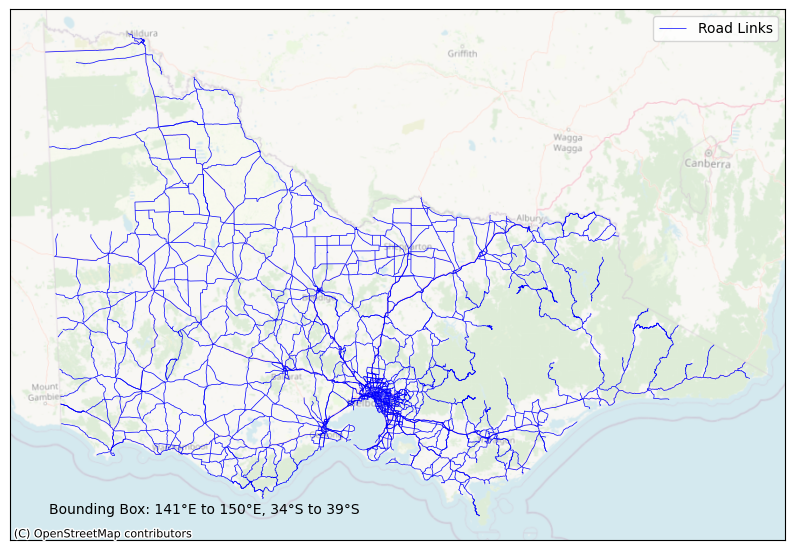

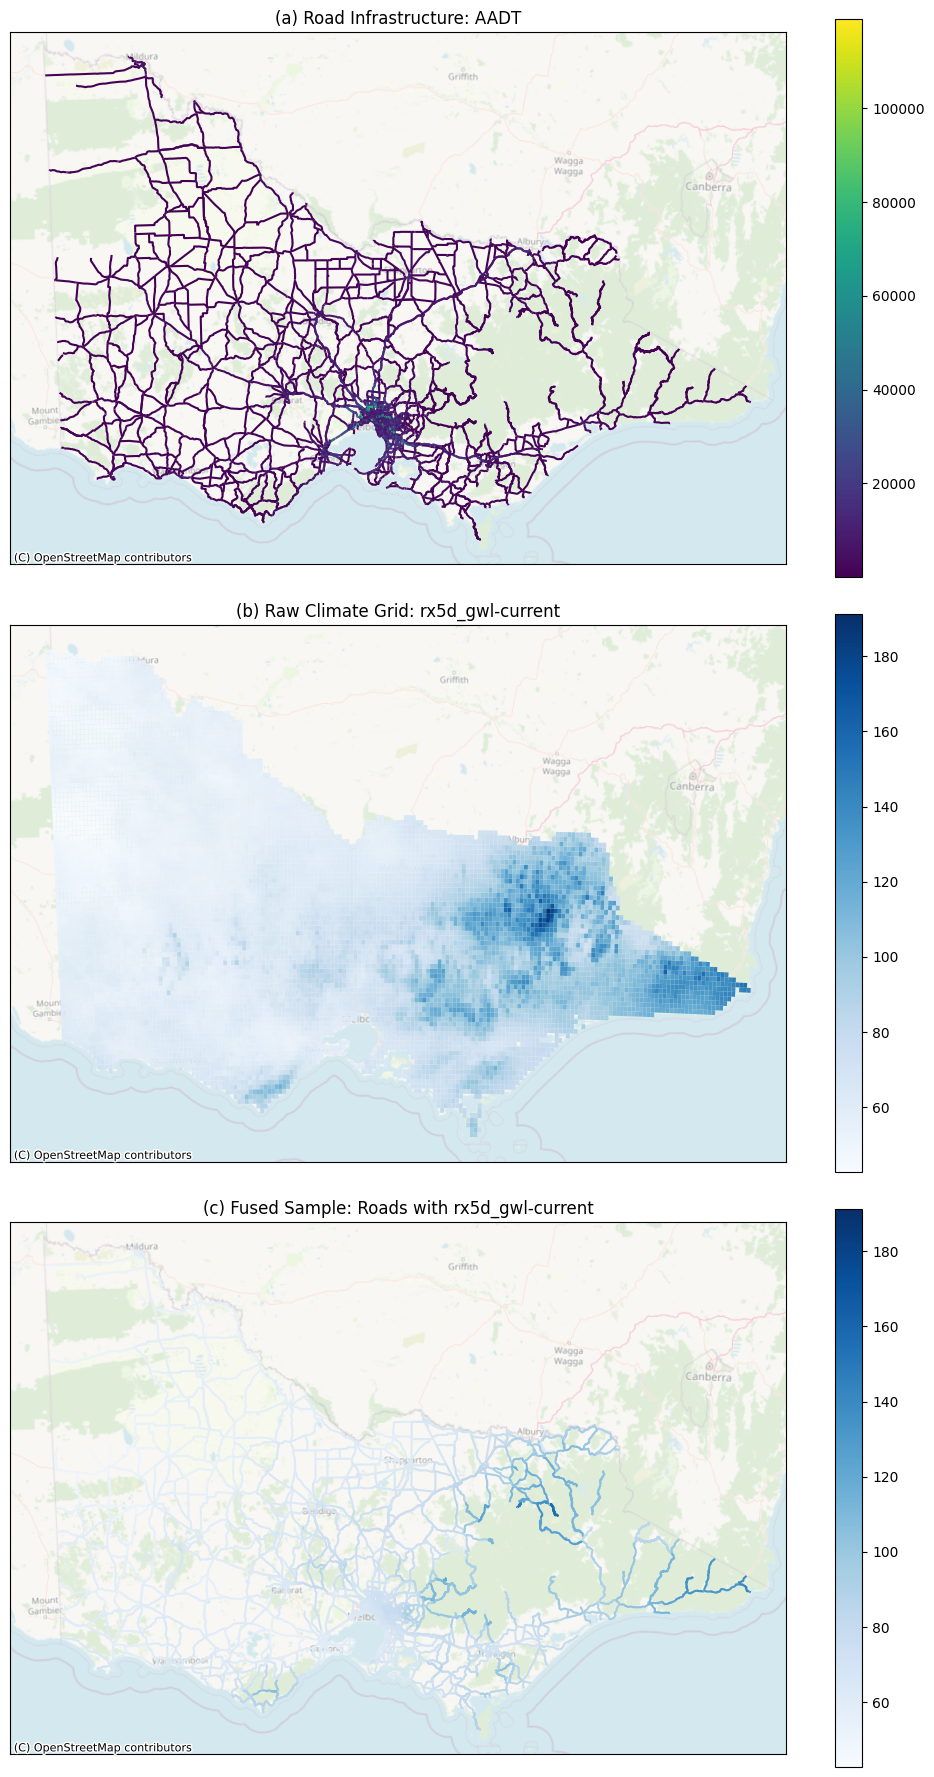

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import contextily as cx

# Load the fused dataset (adjust path if needed)
gdf = gpd.read_file("../data/processed/gdf_road_clim_cln_final_withfuture.geojson")

# Figure: Spatial Coverage of the Fused Road Network Dataset
# Simple map showing road segments in Victoria
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', linewidth=0.5, label='Road Links')
# ax.set_title('Spatial Distribution of Road Links in Victoria, Australia')
# Remove ticks and labels from x and y axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Add a lighter basemap with reduced opacity
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
# Bounding box annotation
ax.annotate('Bounding Box: 141°E to 150°E, 34°S to 39°S', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)
plt.legend()
plt.savefig('../outputs/fig_road_network_coverage.png', dpi=300)
plt.show()

# Figure: Example of Fused Data Attributes
# Multi-panel: Raw road, raw climate (sample), fused (zoomed subset) - Vertical layout
sample_gdf = gdf  # gdf.iloc[:100].copy()

# Load raw climate data to determine unified scale
raw_climate = gpd.read_file("../data/raw/climate_data/extreme_rainfall_aus_rx5d_gwl-current_250316_vic.json")

# Determine unified vmin and vmax for rx5d_gwl-c and rx5d_gwl-current
vmin = min(raw_climate['rx5d_gwl-c'].min(), sample_gdf['rx5d_gwl-current'].min())
vmax = max(raw_climate['rx5d_gwl-c'].max(), sample_gdf['rx5d_gwl-current'].max())

# Panel 1: Raw road attributes (e.g. AADT on roads)
fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows, 1 column, adjusted height for vertical layout
sample_gdf.plot(column='ALLVEHS_AA', ax=axs[0], cmap='viridis', legend=True, norm=Normalize(vmin=sample_gdf['ALLVEHS_AA'].min(), vmax=sample_gdf['ALLVEHS_AA'].max()))
axs[0].set_title('(a) Road Infrastructure: AADT')
# Remove ticks and labels from x and y axes for panel 1
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
# Add a lighter basemap with reduced opacity
cx.add_basemap(axs[0], crs=sample_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)

# Panel 2: Raw climate (load a sample raw climate file, e.g. rx5d_gwl-current)
raw_climate.plot(column='rx5d_gwl-c', ax=axs[1], cmap='Blues', legend=True, norm=Normalize(vmin=vmin, vmax=vmax))
axs[1].set_title('(b) Raw Climate Grid: rx5d_gwl-current')
# Remove ticks and labels from x and y axes for panel 2
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
# Add a lighter basemap with reduced opacity
cx.add_basemap(axs[1], crs=raw_climate.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)

# Panel 3: Fused (roads with overlaid climate attribute)
sample_gdf.plot(column='rx5d_gwl-current', ax=axs[2], cmap='Blues', legend=True, norm=Normalize(vmin=vmin, vmax=vmax))
axs[2].set_title('(c) Fused Sample: Roads with rx5d_gwl-current')
# Remove ticks and labels from x and y axes for panel 3
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
# Add a lighter basemap with reduced opacity
cx.add_basemap(axs[2], crs=sample_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.tight_layout()
plt.savefig('../outputs/fig_fused_data_example.png', dpi=300)
plt.show()

## Citation and License

If using this dataset or code, please cite:
- Dataset: Chin, T.K. (2025). *Fused Geospatial Dataset of Road Infrastructure and Climate Hazards for Victoria, Australia.*
Zenodo. [https://doi.org/10.5281/zenodo.17379391](https://doi.org/10.5281/zenodo.17379391)
- Code: Chin, T.K. (2025). *RICRAF: Road Infrastructure Climate Risk Assessment Framework (Code Repository).*
Zenodo. [https://doi.org/10.5281/zenodo.17391486](https://doi.org/10.5281/zenodo.17391486)

**License:** MIT (see LICENSE file in repository).

## References

- Geopandas Documentation: https://geopandas.org/
- DataVic Road Data: https://www.data.vic.gov.au/
- Australian Climate Service: https://www.acs.gov.au/


